In [388]:
%load_ext autoreload
%autoreload 2

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import time
import glob
import os
import pickle
import itertools
import numpy as np
import pandas as pd
import torch
from test_functions import find_max, problem_setup
import seaborn as sns
import matplotlib as mpl
mpl.rcParams["figure.dpi"]= 100
import matplotlib.pylab as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [389]:
kernel = "default"
problem_strs_dict = {
    'osy_6d8d_piecewiselinear': 'OSY (d=6, k=8) \n Piece-wise linear',
    "carcabdesign_7d9d_piecewiselinear": "Car cab design (d=7, k=9) \n Piece-wise linear", 
    'dtlz2_8d4d_negl1dist': 'DTLZ2 (d=8, k=4) \n L1 distance',
    "vehiclesafety_5d3d_kumaraswamyproduct": "Vehicle safety (d=5, k=3) \n Product of Kumaraswamy CDFs",
    
    'osy_6d8d_sigmodconstraints': 'OSY (d=6, k=8) \n Exp. util. sum with sigmoid constraints',
    "carcabdesign_7d9d_linear": "Car cab design (d=7, k=9) \n Linear",
    "dtlz2_8d4d_piecewiselinear": "DTLZ2 (d=8, k=4) \n Piece-wise linear",
    "vehiclesafety_5d3d_piecewiselinear": "Vehicle safety (d=5, k=3) \n Piece-wise linear",
}

mt_problem_strs_dict = {
    'osy_6d8d_piecewiselinear': 'OSY (d=6, k=8) \n Piece-wise linear',
    "carcabdesign_7d9d_piecewiselinear": "Car cab design (d=7, k=9) \n Piece-wise linear", 
    'dtlz2_8d4d_negl1dist': 'DTLZ2 (d=8, k=4) \n L1 distance',
    "vehiclesafety_5d3d_kumaraswamyproduct": "Vehicle safety (d=5, k=3) \n Product of Kumaraswamy CDFs",
}


max_utils = {}
problems = {}
util_funcs = {}
for problem_str in problem_strs_dict.keys():
    X_dim, Y_dim, problem, util_type, get_util, Y_bounds, probit_noise = problem_setup(problem_str, dtype=torch.double)
    problems[problem_str] = problem
    util_funcs[problem_str] = get_util
    if problem_str not in max_utils:
        _, max_utils[problem_str] = find_max(problem, get_util)        

osy_6d8d_piecewiselinear, noisy: False, noise_std: 0
carcabdesign_7d9d_piecewiselinear, noisy: False, noise_std: 0
dtlz2_8d4d_negl1dist, noisy: False, noise_std: 0
vehiclesafety_5d3d_kumaraswamyproduct, noisy: False, noise_std: 0
osy_6d8d_sigmodconstraints, noisy: False, noise_std: 0
carcabdesign_7d9d_linear, noisy: False, noise_std: 0
dtlz2_8d4d_piecewiselinear, noisy: False, noise_std: 0
vehiclesafety_5d3d_piecewiselinear, noisy: False, noise_std: 0


In [390]:
# Plot display labels      
def read_pickles(folders):
    sim_results = []
    for folder in folders:
        for fname in glob.iglob(os.path.join(folder, "*.pickle")):
            one_sim_results = pickle.load(open(fname, "rb"))
            for sr in one_sim_results:
                sr["filepath"] = fname
            sim_results = sim_results + one_sim_results
    print(f"Read in {len(sim_results)} entries.")
    return sim_results

## Process within session data

In [674]:
# within-session simulation preference learning strategy names
strategy_dict = {
    "random_random": "Surrogate Random",
    "parego_pref_lookahead_pm": "qNParEGO init lookahead PM",
    "parego_pref_lookahead_ei": "qNParEGO init lookahead EI",
    "random_ps_pref_lookahead_pm": "Lookahead PM",
    "random_ps_pref_lookahead_ei": "Lookahead EI",
    "random_ps_unei": "uNEI",
    "parego_unei": "qNParEGO init uNEI",
    "random_ps_qnei": "uNEI-PM",
    "parego_qnei": "qNParEGO init uNEI-PM",
    "parego_parego": "qNParEGO-PL",
    "observed_observed": "Observed (A&F'20)",
    "random_ps_lookahead_discrete_timse_pm": "Lookahead tIMSE-PM",
    "random_ps_nonflat_lookahead_pm": "Lookahead Non-flat PM",
    "random_ps_qpnei": "qPNEI",
    "random_ps_qpnei_single_baseline": "qPNEI (Single incumbent)",
    "random_ps_max_var": "Max variance",
    "random_ps_pref_optimal": "Pref Optimal",
    "random_ps_bald_correct": "BALD f_mean",
    "random_ps_expected_util": "EUBO",
    "random_ps_expected_util_rw": "EUBO",
    "uncorrelated_uncorrelated": r"Random-$\mathcal{Y}_0$",    
    "random_ps_bald_yspace": r"BALD-$\mathcal{Y}_0 (surrogate init)$",
    "random_ps_eubo_y": r"EUBO-$\mathcal{Y}_0 (surrogate init)$",
    "uncorrelated_bald_yspace": r"BALD-$\mathcal{Y}_0$",
    "uncorrelated_eubo_y": r"EUBO-$\mathcal{Y}_0$",
    "random_ps_random_ps": r"Random-$\tilde{f}$",
    "random_ps_bald_rff": r"BALD-$\tilde{f}$",
    "random_ps_eubo_rff": r"EUBO-$\tilde{f}$",
    "random_ps_eubo_rff_rw": r"EUBO-$\tilde{f}$",
    "random_ps_eubo_one_sample": r"EUBO-$\zeta$"
}

# Reading
folders = [
    "../data/sim_results/within_session/camera_ready",
]
sim_results = read_pickles(folders)

clean_df = []
for single_result in sim_results:
    # load problem info
    problem_str = single_result["problem_str"]
    if problem_str not in problems:
        continue
    
    problem = problems[problem_str]
    util_func = util_funcs[problem_str]
    
    # clean up raw data
    if "learn_strategy" not in single_result:
        single_result["learn_strategy"] = "qnei"

    if "sample_outcome" not in single_result:
        single_result["sample_outcome"] = True

    if single_result["learn_strategy"] in ["observed", "uncorrelated"]: 
        single_result["sample_outcome"] = None
    
    # set strategy name
    strategy_name = strategy_dict[single_result["init_strategy"] + "_" + single_result["learn_strategy"]]
        
    # parse single sim data
    eval_util = util_func(problem.evaluate_true(single_result["eval_X"])).tolist()
    indices = single_result["post_mean_idx"]
    
    for i in range(len(eval_util)):
        df_entry = {
            "problem_str": problem_str,
            "strategy_name": strategy_name,
            "keep_winner_prob": single_result['keep_winner_prob'],
            "sim_idx": indices[i],
            "util": eval_util[i],
            "max_util": max_utils[problem_str],
            "log_opt_gap": np.log(max_utils[problem_str] - eval_util[i]),
            "noiseless": bool(single_result['noise_std'] == 0)
        }
        clean_df.append(df_entry)
        
clean_df = pd.DataFrame(clean_df)
# Keep top 30
clean_df = clean_df.groupby(["problem_str", "strategy_name", "sim_idx", "noiseless", "keep_winner_prob"]).head(100)

# Calculate summary statistics
plot_df = (clean_df.groupby(["problem_str", "strategy_name", "sim_idx", "noiseless", "keep_winner_prob"])
    .agg({
        "util": ["mean", "std", "count"],
        "log_opt_gap": ["mean", "std"],
        "max_util": ["first"]
    }))
plot_df.columns = ['_'.join(col) for col in plot_df.columns.to_flat_index()]
colnames = []
for cn in list(plot_df.columns):
    cn = cn.replace("util_count", "count")
    cn = cn.replace("max_util_first", "max_util")
    colnames.append(cn)
plot_df.columns = colnames

plot_df['util_se'] = plot_df['util_std'] / np.sqrt(plot_df['count'])
plot_df['log_opt_gap_se'] = plot_df['log_opt_gap_std'] / np.sqrt(plot_df['count'])

plot_df = plot_df.reset_index()

Read in 13050 entries.


['BALD-$\\mathcal{Y}_0$' 'BALD-$\\tilde{f}$' 'EUBO-$\\mathcal{Y}_0$'
 'EUBO-$\\tilde{f}$' 'EUBO-$\\zeta$' 'Random-$\\mathcal{Y}_0$'
 'Random-$\\tilde{f}$']


,problem_str,strategy_name,sim_idx,noiseless,keep_winner_prob,util_mean,util_std,count,log_opt_gap_mean,log_opt_gap_std,max_util,util_se,log_opt_gap_se
0,carcabdesign_7d9d_linear,BALD-$\mathcal{Y}_0$,0,True,0,4.969113,0.453538,100,0.053525,0.415191,6.114008e+00,0.045354,0.041519
627,osy_6d8d_sigmodconstraints,BALD-$\tilde{f}$,75,True,0,1.820409,1.469575,100,0.255424,0.935869,3.722850e+00,0.146958,0.093587
628,osy_6d8d_sigmodconstraints,BALD-$\tilde{f}$,79,True,0,1.912129,1.479764,100,0.183026,0.945791,3.722850e+00,0.147976,0.094579
629,osy_6d8d_sigmodconstraints,EUBO-$\mathcal{Y}_0$,0,True,0,0.002968,0.024003,100,1.313670,0.006646,3.722850e+00,0.002400,0.000665
630,osy_6d8d_sigmodconstraints,EUBO-$\mathcal{Y}_0$,5,True,0,0.034074,0.298292,100,1.297263,0.160368,3.722850e+00,0.029829,0.016037
...,...,...,...,...,...,...,...,...,...,...,...,...,...
322,dtlz2_8d4d_negl1dist,EUBO-$\zeta$,79,True,0,-0.568741,0.186137,100,-0.619164,0.339303,-1.428334e-07,0.018614,0.033930
323,dtlz2_8d4d_negl1dist,Random-$\mathcal{Y}_0$,0,True,0,-1.318890,0.380525,100,0.232414,0.309934,-1.428334e-07,0.038053,0.030993
324,dtlz2_8d4d_negl1dist,Random-$\mathcal{Y}_0$,5,True,0,-1.225919,0.409277,100,0.147238,0.349442,-1.428334e-07,0.040928,0.034944
312,dtlz2_8d4d_negl1dist,EUBO-$\zeta$,30,True,0,-0.768219,0.264353,100,-0.326369,0.369084,-1.428334e-07,0.026435,0.036908


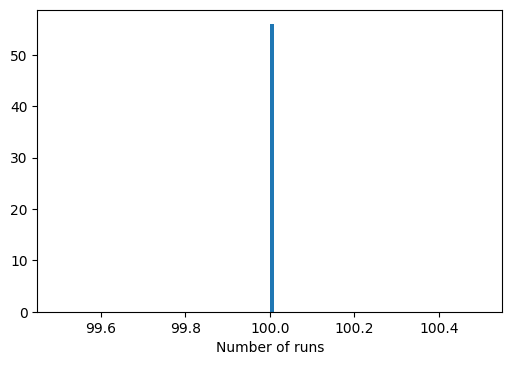

In [675]:
plt.hist(plot_df[plot_df['sim_idx'] == 0]['count'], bins=100)
plt.xlabel("Number of runs")

plot_df = plot_df[(plot_df['keep_winner_prob'].isin([0, 1])) & (plot_df['noiseless'])]
plot_df.to_pickle("../data/processed/within_session.pickle")
print(plot_df['strategy_name'].unique())
plot_df.sort_values('count')

In [676]:
progress_df = plot_df.query("sim_idx == 0").sort_values(['strategy_name', 'problem_str'])
pd.pivot_table(progress_df, values='count', index=['problem_str'], columns=['strategy_name'], aggfunc=np.sum)

strategy_name,BALD-$\mathcal{Y}_0$,BALD-$\tilde{f}$,EUBO-$\mathcal{Y}_0$,EUBO-$\tilde{f}$,EUBO-$\zeta$,Random-$\mathcal{Y}_0$,Random-$\tilde{f}$
problem_str,,,,,,,
carcabdesign_7d9d_linear,100,100,100,100,100,100,100
carcabdesign_7d9d_piecewiselinear,100,100,100,100,100,100,100
dtlz2_8d4d_negl1dist,100,100,100,100,100,100,100
dtlz2_8d4d_piecewiselinear,100,100,100,100,100,100,100
osy_6d8d_piecewiselinear,100,100,100,100,100,100,100
osy_6d8d_sigmodconstraints,100,100,100,100,100,100,100
vehiclesafety_5d3d_kumaraswamyproduct,100,100,100,100,100,100,100
vehiclesafety_5d3d_piecewiselinear,100,100,100,100,100,100,100


## Clean multi-batch data

In [667]:
def clean_single_result(single_result):
    if 'one_shot' not in single_result:
        sr['one_shot'] = False

    if "sample_outcome" not in single_result:
        single_result["sample_outcome"] = True

    if single_result["policy"] in ["observed", "uncorrelated"]: 
        single_result["sample_outcome"] = None
    
    if "keep_winner_prob" not in single_result:
        if single_result["policy"] in ["pref", "ri_pref", "parego_pref"]:
            single_result["keep_winner_prob"] = 0.8
        else:
            single_result["keep_winner_prob"] = 0   
            
    if single_result["policy"] in ["parego_only", "true_util_seq", "pbo_ts", "pbo_ei"]: 
        single_result["keep_winner_prob"] = -1
        
    if 'comp_noise_type' not in single_result:
        single_result['comp_noise_type'] = "constant"
        single_result['comp_noise'] = 0.1
        
    return single_result

def classify_exp_type(single_result):
    # resopnse surfaces noise
    if single_result['noise_std'] == 0:
        noisy_f = "noiseless_f"
    else:
        noisy_f = "noisy_f"

    # comparison noise
    if single_result['comp_noise'] == 0:
        comp_noise_type = "no_comp_noise"
    elif single_result['comp_noise_type'] == "constant":
        comp_noise_type = "const_comp_noise"
    elif single_result['comp_noise_type'] == "probit":
        comp_noise_type = "probit_comp_noise"
    else:
        raise UnsupportedError("Wrong comp noise")

    # different batch size
    X_dim = single_result['outcome_X'].shape[-1]
    if X_dim <= 5:
        if single_result['init_n_outcome'] == 32:
            batch_size = "large_batch"
        elif single_result['init_n_outcome'] == 16:
            batch_size = "normal_batch"
        else:
            raise UnsupportedError("Unknown batch")
    else:
        if single_result['init_n_outcome'] == 64:
            batch_size = "large_batch"
        elif single_result['init_n_outcome'] == 32:
            batch_size = "normal_batch"
        else:
            raise UnsupportedError("Unknown batch")

    # one shot
    if single_result['one_shot']:
        pe_mode = "one_shot"
    else:
        pe_mode = "interactive"

    exp_components = [noisy_f, comp_noise_type, batch_size, pe_mode]
    exp_type_str = " ".join(exp_components)
    
    return exp_type_str

In [668]:
# batch simulation names
policy_dict = {
    "parego_only": "MOBO (qNParEGO)",
    "true_util_seq": "True Utility",
    "random": "Surrogate Random",
    "ri_unei": "uNEI-RW",
    "unei": "qNParEGO init uNEI-RW",
    "pref_lookahead_pm": "qNParEGO init lookahead PM",
    "pref_lookahead_ei": "qNParEGO init lookahead EI",
    "ri_pref_lookahead_pm": "Lookahead PM",
    "ri_pref_lookahead_ei": "Lookahead EI",
    "ri_pref": "uNEI-PM-RW",
    "pref": "qNParEGO init uNEI-PM-RW",
    "parego_pref": "qNParEGO-PL-RW",
    "observed": "Observed (A&F'20)",
    "ri_lookahead_discrete_timse_pm": "Lookahead tIMSE-PM",
    "ri_nonflat_lookahead_pm": "Lookahead Non-flat PM",
    "ri_qpnei": "qPNEI",
    "ri_qpnei_single_baseline": "qPNEI (Single incumbent)",
    "ri_max_var": "Max variance",
    "ri_pref_optimal": "Pref Optimal",
    "ri_bald": "BALD (buggy)",
    "ri_bald_correct": "BALD",
    "ri_expected_util": "EUBO",
    "ri_expected_util_rw": "EUBO-RW",
    "ri_bald_correct": "BALD f_mean",
    "ri_eubo_rff_rw": "EUBO-PS-RW",
    "pbo_ts": "PBO TS (random)",
    "pbo_ei": "PBO EI (random)",
    "pbo_ei_pe_ts": "PBO TS",
    "pbo_ei_pe_eubo": "PBO EUBO",
    "uncorrelated": r"Random-$\mathcal{Y}_0$",    
    "ri_bald_yspace": r"BALD-$\mathcal{Y}_0$",
    "ri_eubo_y": r"EUBO-$\mathcal{Y}_0$",
    "random_ps": r"Random-$\tilde{f}$",    
    "ri_bald_rff": r"BALD-$\tilde{f}$",    
    "ri_eubo_rff": r"EUBO-$\tilde{f}$",
    "ri_eubo_one_sample": r"EUBO-$\zeta$",
    "random_exp": "Random Experiment",
}
    
# Reading
folders = [
# =========== camera ready ==========
    "../data/sim_results/multi_batch/camera_ready/interactive",
    "../data/sim_results/multi_batch/camera_ready/one_shot",
    "../data/sim_results/multi_batch/camera_ready/probit_noise",
]
sim_results = read_pickles(folders)

# Update best values
for single_result in sim_results:
    # load problem info
    problem_str = single_result["problem_str"]
    if problem_str not in problems:
        continue
    problem = problems[problem_str]
    util_func = util_funcs[problem_str]
    
    best_val = max_utils[problem_str]
    seen_util = util_func(problem.evaluate_true(single_result["outcome_X"]))
    if seen_util.max() >= best_val:
        argmax = seen_util.argmax()
        max_utils[problem_str] = seen_util[argmax].item()
        
clean_df = []
for single_result in sim_results:
    # === load problem info ===
    problem_str = single_result["problem_str"]
    if problem_str not in problems:
        continue
    problem = problems[problem_str]
    util_func = util_funcs[problem_str]
    
    # === clean up raw data ===
    single_result = clean_single_result(single_result)
    exp_type_str = classify_exp_type(single_result)

    n_batch = single_result["n_batch"]
    batch_size = single_result["batch_size"]
    
    if "gen_batch_size" not in single_result:
        single_result["gen_batch_size"] = batch_size
        single_result["init_n_outcome"] = batch_size
    
    init_n_outcome = single_result["init_n_outcome"]
    gen_batch_size = single_result["gen_batch_size"]
        
    policy_name = f'{policy_dict[single_result["policy"]]}'

    # === Parsing multi-batch data ===
    batch_boundaries = [init_n_outcome + batch_size * i for i in range(n_batch + 1)]
    # check boundary calculation
    assert(single_result["outcome_Y"].shape[0] == batch_boundaries[-1])
    
    utils = util_func(problem.evaluate_true(single_result["outcome_X"]))
    for i, end in enumerate(batch_boundaries):
        utils_until_batch_i = utils[:end]
        batch_df = {
            "policy": policy_name,
            "init_seed": single_result['init_seed'],
            "keep_winner_prob": single_result['keep_winner_prob'],
            "batch": i,
            "cum_regret": (max_utils[problem_str] - utils_until_batch_i).sum().item(),
            "log_opt_gap": (max_utils[problem_str] - utils_until_batch_i.max() + 1e-3).log().item(),
            "max_util": utils_until_batch_i.max().item(),
            "cum_util": utils_until_batch_i.sum().item(),
            "problem_str": problem_str,
            "noiseless": bool(single_result['noise_std'] == 0),
            "comp_noise_type": single_result['comp_noise_type'],
            "comp_noise": single_result['comp_noise'],
            "exp_type_str": exp_type_str,
        }
        clean_df.append(batch_df)
clean_df = pd.DataFrame(clean_df)

# Keep top 30
clean_df = clean_df.groupby(["problem_str", "policy", "batch", "exp_type_str"]).head(30)

# post calculation
plot_df = (clean_df.groupby(["problem_str", "policy", "batch", "exp_type_str"])
    .agg({
        "cum_regret": ["mean", "std", "count"],
        "log_opt_gap": ["mean", "std"],
        "max_util": ["mean", "std"],
        "cum_util":  ["mean", "std"],
    }))
plot_df.columns = ['_'.join(col) for col in plot_df.columns.to_flat_index()]
colnames = []
for cn in list(plot_df.columns):
    cn = cn.replace("cum_regret_count", "count")
    colnames.append(cn)
plot_df.columns = colnames
plot_df['cum_regret_se'] = plot_df['cum_regret_std'] / np.sqrt(plot_df['count'])
plot_df['log_opt_gap_se'] = plot_df['log_opt_gap_std'] / np.sqrt(plot_df['count'])
plot_df['max_util_se'] = plot_df['max_util_std'] / np.sqrt(plot_df['count'])
plot_df['cum_util_se'] = plot_df['cum_util_std'] / np.sqrt(plot_df['count'])

plot_df = plot_df.reset_index()

Read in 7222 entries.


['BALD-$\\mathcal{Y}_0$' 'BALD-$\\tilde{f}$' 'EUBO-$\\mathcal{Y}_0$'
 'EUBO-$\\tilde{f}$' 'EUBO-$\\zeta$' 'MOBO (qNParEGO)' 'PBO EUBO' 'PBO TS'
 'Random Experiment' 'Random-$\\mathcal{Y}_0$' 'Random-$\\tilde{f}$'
 'True Utility']


Text(0.5, 0, 'Number of runs')

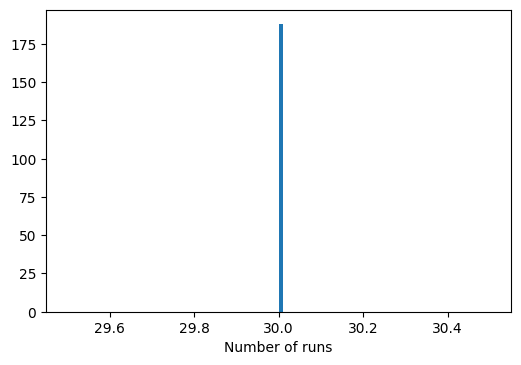

In [669]:
exclude_policies = [
    'Pref Optimal',
    'qPNEI (Single incumbent)',
    'BALD (buggy)',
    'EUBO-RW',
    'EUBO',
    "BALD f_mean",
    "Surrogate Random",
    "PBO TS (random)",
    "PBO EI (random)",
]
filtered_df = plot_df
# filtered_df = plot_df.query("count > 5")
filtered_df = filtered_df[~(filtered_df['policy'].isin(exclude_policies))]
filtered_df.to_pickle("../data/processed/multi_batch.pickle")
print(filtered_df['policy'].unique())
filtered_df

# Plot the number of iterations finished
plt.hist(filtered_df[filtered_df['batch'] == 0]['count'], bins=100)
plt.xlabel("Number of runs")

In [670]:
group_check_df = filtered_df[filtered_df['problem_str'].isin(problem_strs_dict.keys())]
for name, group in group_check_df.groupby('exp_type_str'):
    print(name)
    progress_df = group.query("batch == 0").sort_values(['policy', 'problem_str'])
    display(pd.pivot_table(progress_df, values='count', index=['problem_str'], columns=['policy'], aggfunc=np.sum))

noiseless_f const_comp_noise normal_batch interactive


policy,BALD-$\mathcal{Y}_0$,BALD-$\tilde{f}$,EUBO-$\mathcal{Y}_0$,EUBO-$\tilde{f}$,EUBO-$\zeta$,MOBO (qNParEGO),PBO EUBO,PBO TS,Random Experiment,Random-$\mathcal{Y}_0$,Random-$\tilde{f}$,True Utility
problem_str,,,,,,,,,,,,
carcabdesign_7d9d_linear,30,30,30,30,30,30,30,30,30,30,30,30
carcabdesign_7d9d_piecewiselinear,30,30,30,30,30,30,30,30,30,30,30,30
dtlz2_8d4d_negl1dist,30,30,30,30,30,30,30,30,30,30,30,30
dtlz2_8d4d_piecewiselinear,30,30,30,30,30,30,30,30,30,30,30,30
osy_6d8d_piecewiselinear,30,30,30,30,30,30,30,30,30,30,30,30
osy_6d8d_sigmodconstraints,30,30,30,30,30,30,30,30,30,30,30,30
vehiclesafety_5d3d_kumaraswamyproduct,30,30,30,30,30,30,30,30,30,30,30,30
vehiclesafety_5d3d_piecewiselinear,30,30,30,30,30,30,30,30,30,30,30,30


noiseless_f const_comp_noise normal_batch one_shot


policy,BALD-$\mathcal{Y}_0$,BALD-$\tilde{f}$,EUBO-$\mathcal{Y}_0$,EUBO-$\tilde{f}$,EUBO-$\zeta$,PBO EUBO,PBO TS,Random-$\mathcal{Y}_0$,Random-$\tilde{f}$
problem_str,,,,,,,,,
carcabdesign_7d9d_linear,30,30,30,30,30,30,30,30,30
carcabdesign_7d9d_piecewiselinear,30,30,30,30,30,30,30,30,30
dtlz2_8d4d_negl1dist,30,30,30,30,30,30,30,30,30
dtlz2_8d4d_piecewiselinear,30,30,30,30,30,30,30,30,30
osy_6d8d_piecewiselinear,30,30,30,30,30,30,30,30,30
osy_6d8d_sigmodconstraints,30,30,30,30,30,30,30,30,30
vehiclesafety_5d3d_kumaraswamyproduct,30,30,30,30,30,30,30,30,30
vehiclesafety_5d3d_piecewiselinear,30,30,30,30,30,30,30,30,30


noiseless_f probit_comp_noise normal_batch interactive


policy,BALD-$\tilde{f}$,EUBO-$\tilde{f}$,EUBO-$\zeta$,PBO EUBO,PBO TS
problem_str,,,,,
carcabdesign_7d9d_piecewiselinear,30,30,30,30,30
dtlz2_8d4d_negl1dist,30,30,30,30,30
osy_6d8d_piecewiselinear,30,30,30,30,30
vehiclesafety_5d3d_kumaraswamyproduct,30,30,30,30,30


## In-sample difference

In [673]:
interactive_final_batch_df = clean_df.query("batch == 3 and exp_type_str == 'noiseless_f const_comp_noise normal_batch interactive'")
oneshot_final_batch_df = clean_df.query("batch == 3 and exp_type_str == 'noiseless_f const_comp_noise normal_batch one_shot'")

paired_final_batch_df = interactive_final_batch_df.merge(oneshot_final_batch_df, on=['problem_str', 'policy', 'init_seed'], how="inner", suffixes=["_interactive", "_oneshot"])
paired_final_batch_df['max_util_diff'] = paired_final_batch_df['max_util_oneshot'] - paired_final_batch_df['max_util_interactive']
paired_final_batch_df = paired_final_batch_df.groupby(['problem_str', 'policy']).agg({
    "max_util_diff": ["mean", "std", "count"]
})
paired_final_batch_df.columns = ['_'.join(col) for col in paired_final_batch_df.columns.to_flat_index()]
paired_final_batch_df['max_util_diff_se'] = paired_final_batch_df['max_util_diff_std'] / np.sqrt(paired_final_batch_df['max_util_diff_count'])
paired_final_batch_df = paired_final_batch_df.reset_index()
paired_final_batch_df.to_pickle("../data/processed/final_batch_diff_interactive_vs_oneshot.pickle")

## Calculate empirical probit noise

In [672]:
probit_empirical_error_df = []

for sr in sim_results:
    if sr['comp_noise_type'] != "probit":
        continue
    problem_str = sr['problem_str']
    policy = sr['policy']
    if "pbo" not in policy:
        utils = util_funcs[problem_str](sr['train_Y'])
    else:
        utils = util_funcs[problem_str](sr['outcome_Y'])        
    train_comps = sr['train_comps']

    util_pairs = utils[train_comps]
    empirical_error_rate = (util_pairs[:, 0] < util_pairs[:, 1]).float().mean().item()

    probit_empirical_error_df.append({
        "problem_str": problem_strs_dict[problem_str],
        "policy": policy_dict[policy],
        "empirical_error_rate": empirical_error_rate,
    })
    
probit_empirical_error_df = pd.DataFrame(probit_empirical_error_df)
probit_empirical_error_df = probit_empirical_error_df.groupby(["problem_str", "policy"])['empirical_error_rate'].mean().reset_index()
probit_empirical_error_df = pd.pivot_table(probit_empirical_error_df, values='empirical_error_rate', index=['problem_str'], columns=['policy'], aggfunc=np.sum)
probit_empirical_error_df = (probit_empirical_error_df * 100).round(1).astype(str) + "%"
# probit_empirical_error_df = probit_empirical_error_df.style.format({'empirical_error_rate': "{:.1%}"})

print(probit_empirical_error_df.to_latex())